In [ ]:
from google.colab import files
uploaded = files.upload()


In [36]:
import pandas as pd

df = pd.read_excel("EV_Charging_Stations_Feb82024.xlsx")
df.head()

# Import SMOTE for handling class imbalance
from imblearn.over_sampling import SMOTE

# Import Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# Initialize SMOTE
smote = SMOTE(random_state=42)



,Station Name,Street Address,City,State,ZIP,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV Network,EV Connector Types,Access Code,Access Detail Code,Facility Type
0,LADWP - Truesdale Center,11797 Truesdale St,Sun Valley,CA,91352,NaN,57.0,2.0,SHELL_RECHARGE,CHADEMO J1772 J1772COMBO,private,NaN,UTILITY
1,Los Angeles Convention Center,1201 S Figueroa St,Los Angeles,CA,90015,NaN,7.0,NaN,Non-Networked,J1772,public,NaN,PARKING_GARAGE
2,LADWP - John Ferraro Building,111 N Hope St,Los Angeles,CA,90012,NaN,338.0,12.0,Non-Networked,CHADEMO J1772 J1772COMBO,private,NaN,UTILITY
3,LADWP - Haynes Power Plant,6801 E 2nd St,Long Beach,CA,90803,NaN,19.0,1.0,Non-Networked,CHADEMO J1772 J1772COMBO,private,NaN,UTILITY
4,LADWP - Harbor Generating Station,161 N Island Ave,Wilmington,CA,90744,NaN,10.0,NaN,Non-Networked,J1772,private,NaN,UTILITY


In [37]:
#Checking each column
df.columns


Index(['Station Name', 'Street Address', 'City', 'State', 'ZIP',
       'EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count',
       'EV Network', 'EV Connector Types', 'Access Code', 'Access Detail Code',
       'Facility Type'],
      dtype='object')

In [38]:
#Cleaning the data
# Check for missing values in key columns
print("\nMissing values in key columns:")
print(df[['EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count']].isnull().sum())

# For simplicity, filled any missing numerical values with 0
df[['EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count']] = df[['EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count']].fillna(0)


Missing values in key columns:
EV Level1 EVSE Num    64467
EV Level2 EVSE Num     8457
EV DC Fast Count      55770
dtype: int64


In [39]:
#Checking for Tesla charging stations exactly and also showing those that are not.
df['is_tesla'] = df['EV Network'].str.contains("tesla", case=False, na=False).astype(int)


# Verify the counts of Tesla vs. non-Tesla entries
print("\nTesla Flag Counts (0 = Non-Tesla, 1 = Tesla):")
print(df['is_tesla'].value_counts())




Tesla Flag Counts (0 = Non-Tesla, 1 = Tesla):
is_tesla
0    58750
1     6384
Name: count, dtype: int64


In [40]:
# Select features and fill any NaN values with 0
features = ['EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count']
X = df[features].fillna(0)

# The target variable is is_tesla (already created via substring search)
y = df['is_tesla']

# Display a quick summary of the feature matrix
print("\nFeature Matrix Preview:")
print(X.head())


Feature Matrix Preview:
   EV Level1 EVSE Num  EV Level2 EVSE Num  EV DC Fast Count
0                 0.0                57.0               2.0
1                 0.0                 7.0               0.0
2                 0.0               338.0              12.0
3                 0.0                19.0               1.0
4                 0.0                10.0               0.0


In [41]:
# Import the train_test_split function from scikit-learn to split data.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nData split completed. Training set size:", X_train.shape, "Test set size:", X_test.shape)



Data split completed. Training set size: (52107, 3) Test set size: (13027, 3)


In [42]:
# Apply SMOTE to the training data only
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE, training set class distribution:")
print(pd.Series(y_train_res).value_counts())

# Train on the SMOTE-resampled data
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

# Evaluate on the original test set
y_pred = model.predict(X_test)




After SMOTE, training set class distribution:
is_tesla
0    46996
1    46996
Name: count, dtype: int64


In [43]:
#Displaying  how well the model performs by comparing its predictions to the actual values.
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8747217317878253
              precision    recall  f1-score   support

           0       0.96      0.90      0.93     11754
           1       0.41      0.65      0.50      1273

    accuracy                           0.87     13027
   macro avg       0.68      0.77      0.72     13027
weighted avg       0.91      0.87      0.89     13027



The model correctly classifies stations as Tesla or non-Tesla 87.47% of the time. This performance is driven by strong precision for non-Tesla stations (0.96) and a notable improvement in Tesla recall (0.65) after applying SMOTE to balance the classes. While the model does identify more Tesla stations compared to the original version, it does so with lower precision (0.41), meaning some non-Tesla stations are misclassified as Tesla. These results highlight a trade-off between recall and precision when dealing with imbalanced classes and limited features. Still, the model offers meaningful insights into Tesla station characteristics, particularly their association with higher counts of DC fast chargers.

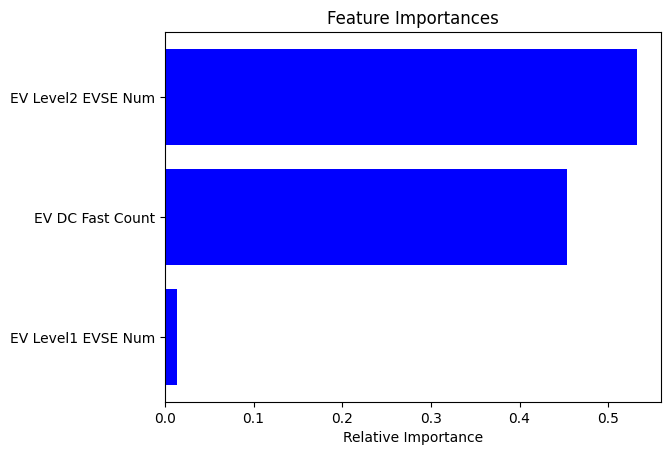

In [44]:
#Visually shows how well the model performed.
import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)

plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


The graph shows that ‘EV Level2 EVSE Num’ is the most influential feature in predicting Tesla stations, followed closely by ‘EV DC Fast Count’. This suggests that Tesla stations are often associated with a higher presence of Level 2 chargers and fast-charging infrastructure. In contrast, ‘EV Level1 EVSE Num’ contributes minimally to the model’s decisions. These insights align with Tesla’s charging design philosophy, which focuses on fast and efficient charging solutions, making Level 2 and DC Fast chargers reliable indicators of potential Tesla Supercharger sites.

Next up...

Based on the model's feature importance and improved ability to identify Tesla stations, the next step is to analyze the dataset at a city level. By grouping stations by city and examining areas with strong EV infrastructure—especially high counts of DC fast chargers—but no current Tesla presence, I aim to identify potential locations where Tesla could consider expanding its Supercharger network. This analysis will help move from prediction to practical recommendations using only the available data.

In [45]:
# Creating a binary column to flag Tesla stations
df['is_tesla'] = df['EV Network'].str.contains("tesla", case=False, na=False).astype(int)

# Group by City and calculate relevant metrics
city_summary = df.groupby('City').agg({
    'EV DC Fast Count': 'sum',
    'EV Level2 EVSE Num': 'sum',
    'EV Level1 EVSE Num': 'sum',
    'is_tesla': 'sum',
    'Station Name': 'count'
}).rename(columns={
    'EV DC Fast Count': 'total_fast_chargers',
    'EV Level2 EVSE Num': 'total_level2_chargers',
    'EV Level1 EVSE Num': 'total_level1_chargers',
    'is_tesla': 'tesla_station_count',
    'Station Name': 'total_station_count'
}).reset_index()

# Cities with strong infrastructure but no Tesla stations
recommended_cities = city_summary[
    (city_summary['total_fast_chargers'] >= 10) &
    (city_summary['tesla_station_count'] == 0)
].sort_values(by='total_fast_chargers', ascending=False)

# Top cities
recommended_cities.head(10)


,City,total_fast_chargers,total_level2_chargers,total_level1_chargers,tesla_station_count,total_station_count
670,Broken Arrow,28.0,20.0,0.0,0,9
1031,Chickasha,28.0,2.0,0.0,0,3
2469,Herndon,27.0,91.0,0.0,0,46
1676,El Cajon,26.0,91.0,0.0,0,55
4594,Porterville,26.0,24.0,1.0,0,15
5267,Silver Spring,23.0,165.0,0.0,0,59
3470,McAlester,21.0,3.0,1.0,0,6
1665,Edmond,20.0,43.0,0.0,0,27
5059,Sand Springs,20.0,1.0,0.0,0,3
3699,Moore,20.0,8.0,0.0,0,4


After analyzing the dataset by city, several locations were identified that have a strong EV charging infrastructure—particularly a high number of DC fast chargers—but currently have no Tesla Supercharger stations. Cities such as Broken Arrow, Chickasha, Herndon, and El Cajon each have 20 or more fast chargers and zero Tesla presence, indicating a potential opportunity for Tesla to expand its Supercharger network. These cities demonstrate the infrastructure readiness to support high-speed charging and could be considered strategic targets for future deployment based on existing demand patterns.

#Now to visualise the Tesla expansion cities on a Map.

In [51]:
import folium
from geopy.geocoders import Nominatim
from time import sleep

# Group by City and calculate summary metrics
city_summary = df.groupby('City').agg({
    'EV DC Fast Count': 'sum',
    'EV Level2 EVSE Num': 'sum',
    'EV Level1 EVSE Num': 'sum',
    'is_tesla': 'sum',
    'Station Name': 'count'
}).rename(columns={
    'EV DC Fast Count': 'total_fast_chargers',
    'EV Level2 EVSE Num': 'total_level2_chargers',
    'EV Level1 EVSE Num': 'total_level1_chargers',
    'is_tesla': 'tesla_station_count',
    'Station Name': 'total_station_count'
}).reset_index()

# Filter for Tesla expansion candidates
recommended_cities = city_summary[
    (city_summary['total_fast_chargers'] >= 10) &
    (city_summary['tesla_station_count'] == 0)
].sort_values(by='total_fast_chargers', ascending=False)

# Limit to top 30 cities for mapping
sample_cities = recommended_cities.head(30).copy()
sample_cities["latitude"] = None
sample_cities["longitude"] = None

# Initialize geolocator with timeout fix
geolocator = Nominatim(user_agent="tesla-expansion-map", timeout=10)

# Geocode city names (US only)
for idx, row in sample_cities.iterrows():
    try:
        location = geolocator.geocode(row["City"], country_codes='us')
        if location:
            sample_cities.at[idx, "latitude"] = location.latitude
            sample_cities.at[idx, "longitude"] = location.longitude
        sleep(1)  # Pause between requests
    except:
        continue

# Create a folium map centered on the US
tesla_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add markers with color-coded icons
for idx, row in sample_cities.iterrows():
    if pd.notnull(row["latitude"]) and pd.notnull(row["longitude"]):
        chargers = row['total_fast_chargers']
        icon_color = 'red' if chargers >= 25 else 'orange' if chargers >= 15 else 'blue'

        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=f"{row['City']}: {int(chargers)} fast chargers",
            icon=folium.Icon(color=icon_color, icon='bolt', prefix='fa')
        ).add_to(tesla_map)

# Save the map to an HTML file
tesla_map.save("tesla_expansion_map.html")

# Display the interactive map
tesla_map


The interactive map above displays the top 30 cities in the United States that have a strong electric vehicle (EV) charging infrastructure—specifically 10 or more DC fast chargers—but currently do not have any Tesla Supercharger stations. Each marker represents one of these cities, color-coded based on the number of fast chargers available:

Red: 25 or more fast chargers

Orange: 15–24 fast chargers

Blue: 10–14 fast chargers

This map visually identifies locations where Tesla could strategically expand its Supercharger network. The geolocation data was obtained using the city names filtered from the dataset and matched via the OpenStreetMap API for U.S. locations. These insights support the overall goal of the project: to recommend future Tesla Supercharger deployment areas using only publicly available EV charging station data.

In [54]:
#Download the map
from google.colab import files
files.download("tesla_expansion_map.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>